In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import joblib
from collections import Counter
from sklearn.linear_model import LogisticRegression

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
pd.set_option('display.max_columns', None)

In [4]:
sns.set(style="whitegrid")# Set seaborn style for plots

In [5]:
df=pd.read_csv('german_credit_data (1).csv')# Load dataset

In [6]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [7]:
df['Age'].describe()# Summary statistics for 'Age' column

count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: Age, dtype: float64

In [8]:
df.isnull().sum()# Check for missing values

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [9]:
df["Risk"].value_counts()# Count occurrences of each category in 'Risk' column

Risk
good    700
bad     300
Name: count, dtype: int64

In [10]:
df.shape

(1000, 11)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [12]:
df.describe(include='all').T#SUMMARY STATISTICS FOR ALL COLUMNS

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,1000.0,NaN,NaN,NaN,499.5,288.819436,0.0,249.75,499.5,749.25,999.0
Age,1000.0,NaN,NaN,NaN,35.546,11.375469,19.0,27.0,33.0,42.0,75.0
Sex,1000,2,male,690,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Job,1000.0,NaN,NaN,NaN,1.904,0.653614,0.0,2.0,2.0,2.0,3.0
Housing,1000,3,own,713,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Saving accounts,817,4,little,603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Checking account,606,3,little,274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit amount,1000.0,NaN,NaN,NaN,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,NaN,NaN,NaN,20.903,12.058814,4.0,12.0,18.0,24.0,72.0
Purpose,1000,8,car,337,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df["Job"].unique()# Unique values in 'Job' column

array([2, 1, 3, 0])

In [14]:
df=df.dropna().reset_index( drop=True)# Drop missing values and reset index

In [15]:
df

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
1,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
2,4,53,male,2,free,little,little,4870,24,car,bad
3,7,35,male,3,rent,little,moderate,6948,36,car,good
4,9,28,male,3,own,little,moderate,5234,30,car,bad
...,...,...,...,...,...,...,...,...,...,...,...
517,989,48,male,1,own,little,moderate,1743,24,radio/TV,good
518,993,30,male,3,own,little,little,3959,36,furniture/equipment,good
519,996,40,male,3,own,little,little,3857,30,car,good
520,998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [16]:
df.columns

Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

In [17]:
df.drop(columns=['Unnamed: 0'], inplace=True)# Drop unnecessary column

In [18]:
df.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

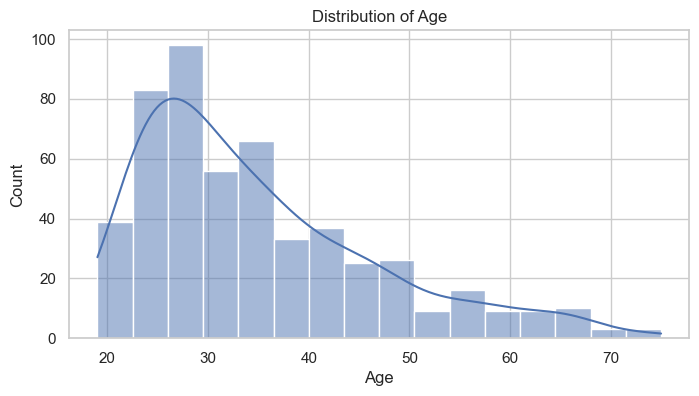

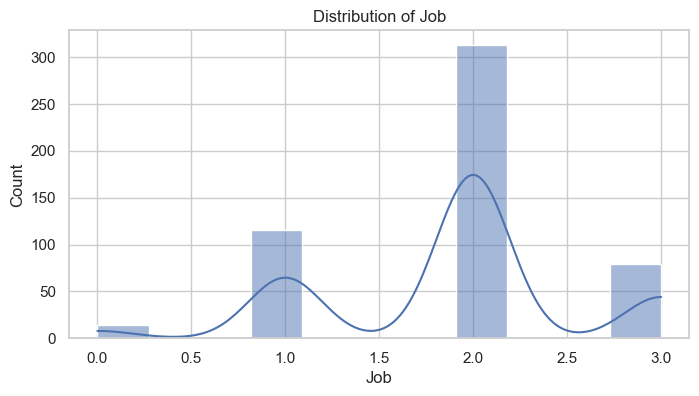

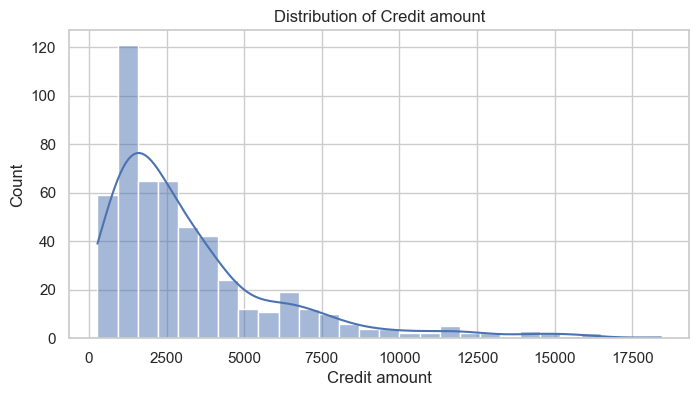

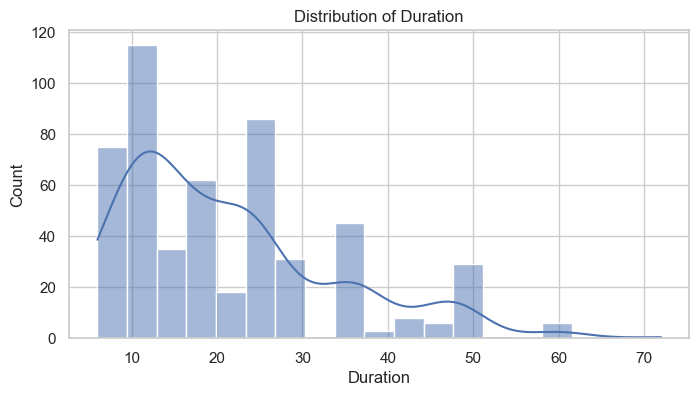

In [19]:
# check univariate distribution of numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()



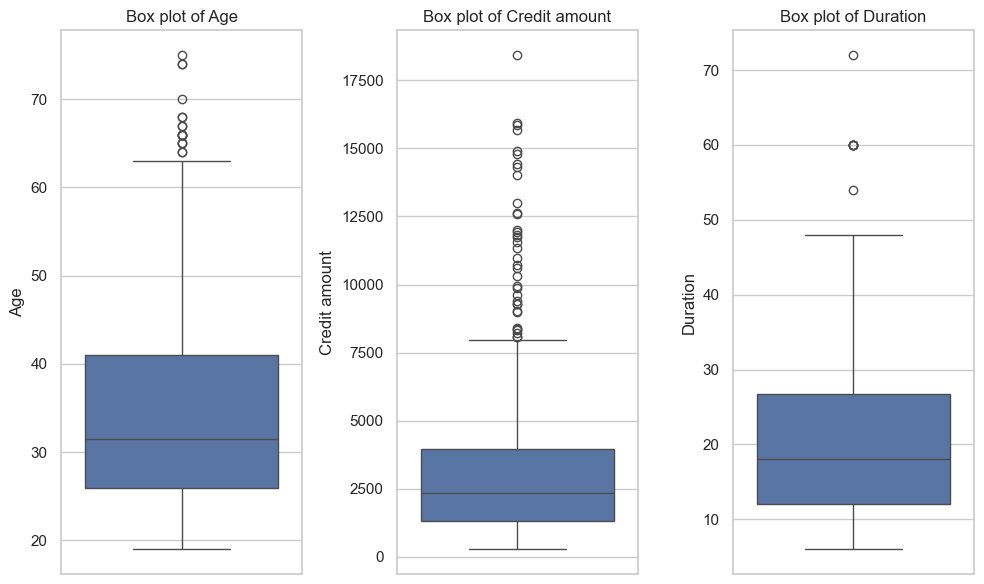

In [20]:
# box plots for numerical columns
plt.figure(figsize=(10, 6))
#exclude job column from numerical columns
numerical_cols = [n for n in numerical_cols if n != 'Job']
for i, col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

In [21]:
df.query('Duration>=60')# Query rows where 'Duration' is greater than 60

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
18,63,male,2,own,little,little,6836,60,business,bad
176,24,female,3,own,moderate,moderate,7408,60,car,bad
199,60,female,3,free,moderate,moderate,14782,60,vacation/others,bad
358,24,male,2,own,moderate,moderate,5595,72,radio/TV,bad
378,27,male,3,own,little,moderate,14027,60,car,bad
489,42,male,2,free,little,moderate,6288,60,education,bad
507,36,male,2,rent,little,little,7297,60,business,bad


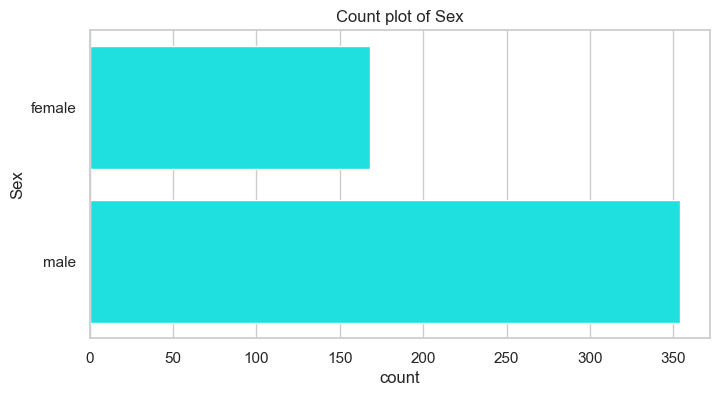

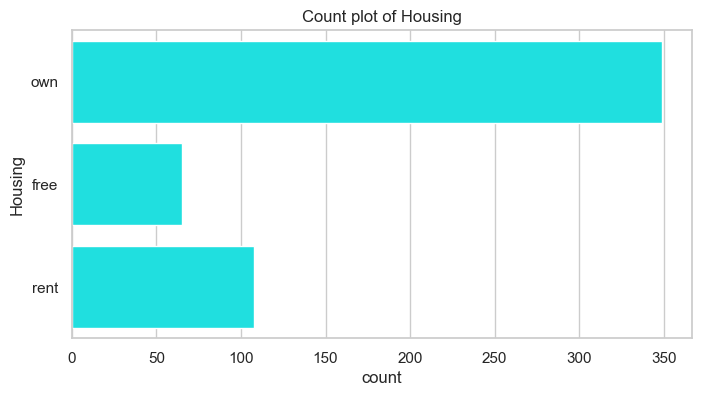

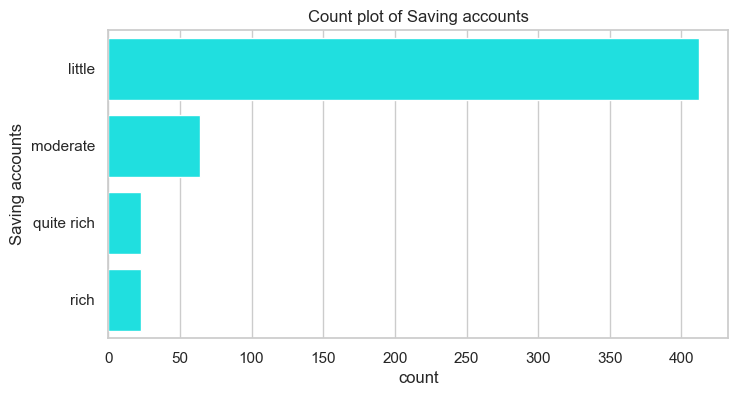

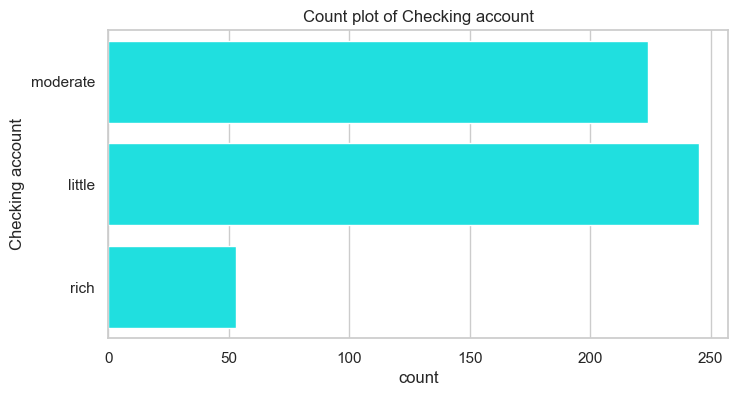

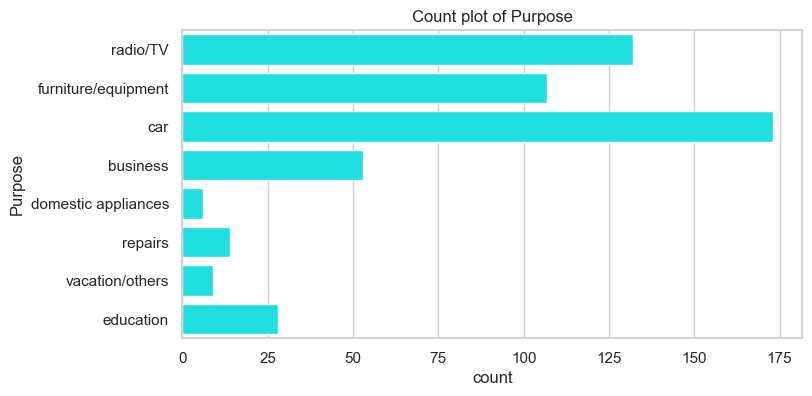

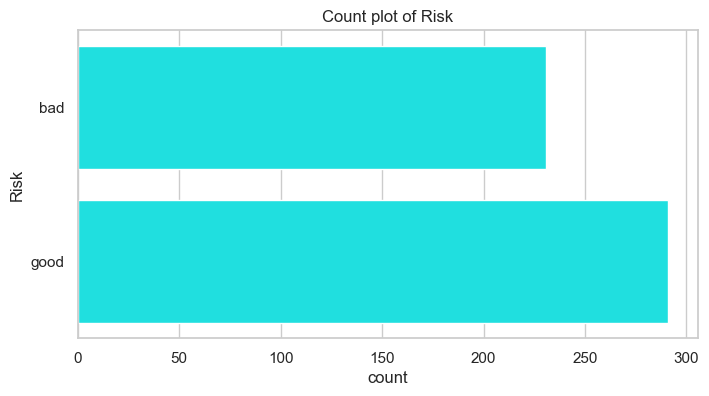

In [22]:
categorial_cols = df.select_dtypes(include='object').columns.tolist()
for i,col in enumerate(categorial_cols):
    plt.figure(figsize=(8, 4))
    sns.countplot(y=df[col],color='cyan')
    plt.title(f'Count plot of {col}')
    plt.show()


In [23]:
corr=df[["Age","Job","Duration","Credit amount"]].corr()# Correlation matrix for selected numerical columns

In [24]:
corr

,Age,Job,Duration,Credit amount
Age,1.000000,0.039771,0.001549,0.082014
Job,0.039771,1.000000,0.200794,0.334721
Duration,0.001549,0.200794,1.000000,0.613298
Credit amount,0.082014,0.334721,0.613298,1.000000


<Axes: >

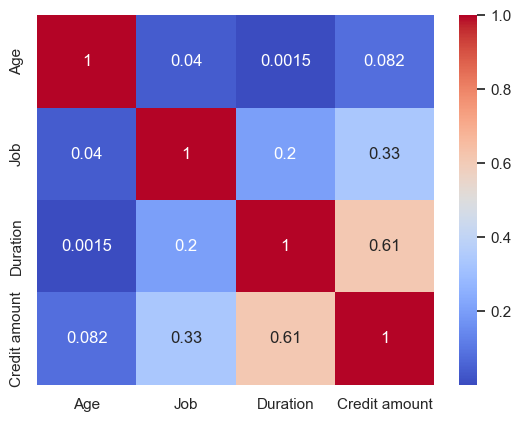

In [25]:
sns.heatmap(corr, annot=True, cmap='coolwarm')# Heatmap of the correlation matrix

In [26]:
df.groupby('Sex')['Credit amount'].mean()# Mean 'Credit amount' grouped by 'Age'

Sex
female    2937.202381
male      3440.833333
Name: Credit amount, dtype: float64

In [27]:
df.groupby("Job")["Credit amount"].mean()# Mean 'Credit amount' grouped by 'Job'


Job
0    1767.857143
1    2250.715517
2    3129.130990
3    5648.784810
Name: Credit amount, dtype: float64

In [28]:
pivot_table=df.pivot_table(values='Credit amount', index='Housing', columns='Purpose')# Pivot table of mean 'Credit amount' by 'Job' and 'Risk'

In [29]:
pivot_table #PIVOT TABLE IS USED TO SUMMARIZE DATA AND SHOW RELATIONSHIPS BETWEEN MULTIPLE VARIABLES

Purpose,business,car,domestic appliances,education,furniture/equipment,radio/TV,repairs,vacation/others
Housing,,,,,,,,
free,4705.000000,5180.314286,NaN,5314.250000,4419.444444,2097.000000,1190.0,7842.666667
own,3725.973684,3120.485437,1333.5,2625.076923,3031.100000,2307.613861,2993.5,10321.833333
rent,6180.833333,3398.285714,NaN,2627.857143,2890.285714,2138.000000,2384.0,NaN


<Axes: xlabel='Age', ylabel='Credit amount'>

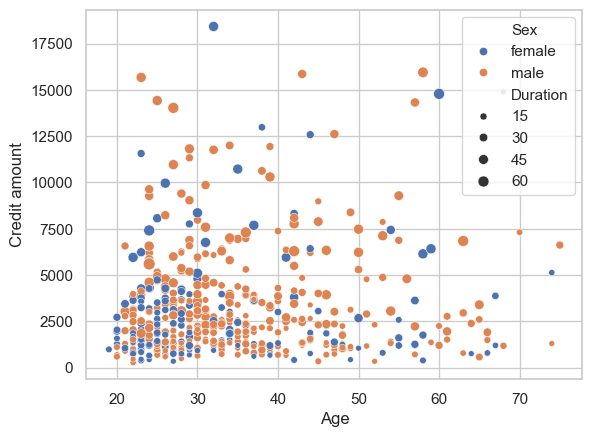

In [30]:
sns.scatterplot(data=df, x='Age', y='Credit amount', hue='Sex',size='Duration')
# Scatter plot of 'Age' vs 'Credit amount' colored by 'Sex'

C:\Users\HP\AppData\Local\Temp\ipykernel_31268\2833077493.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Saving accounts', y='Credit amount', data=df, palette='Set2')


<Axes: xlabel='Saving accounts', ylabel='Credit amount'>

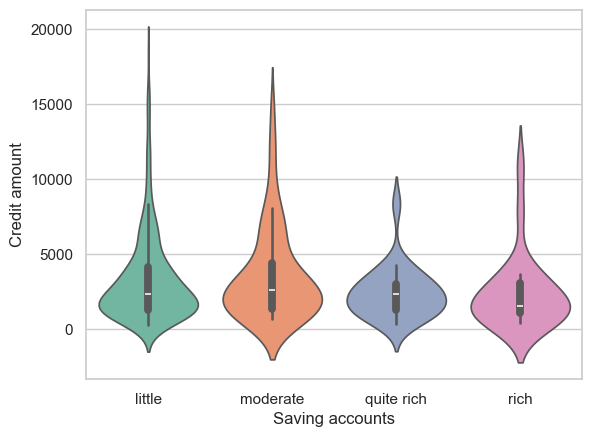

In [31]:
sns.violinplot(x='Saving accounts', y='Credit amount', data=df, palette='Set2')

In [32]:
df["Risk"].value_counts(normalize=True)*100# Proportion of each category in 'Risk' column   

Risk
good    55.747126
bad     44.252874
Name: proportion, dtype: float64

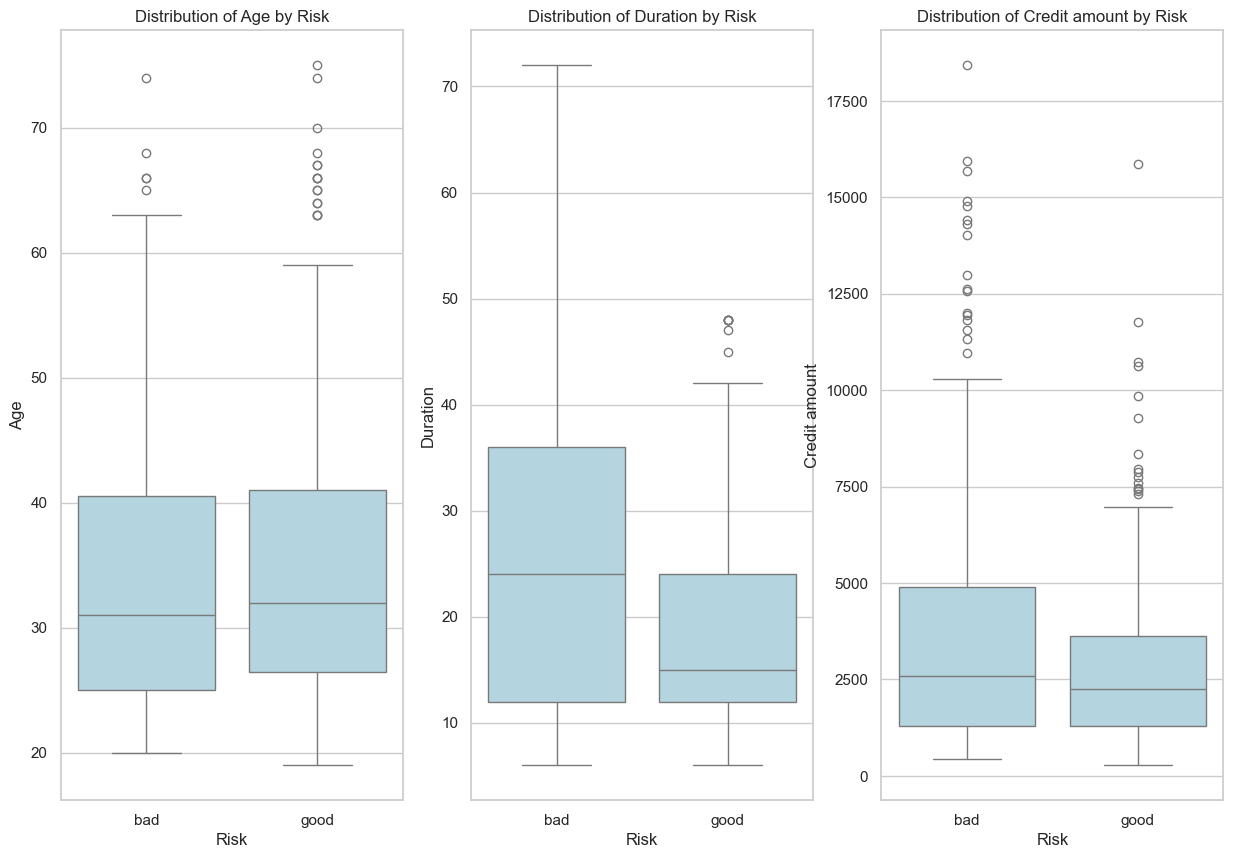

In [33]:
plt.figure(figsize=(15,10))
for i,col in enumerate(["Age","Duration","Credit amount"]):
    plt.subplot(1,3,i+1)
    sns.boxplot(data=df, x='Risk', y=col, color='lightblue')
    plt.title(f'Distribution of {col} by Risk')

In [34]:
df.groupby('Risk')[['Age','Duration','Credit amount']].mean()# Mean of selected numerical columns grouped by 'Risk'

,Age,Duration,Credit amount
Risk,,,
bad,34.147186,25.445887,3881.090909
good,35.477663,18.079038,2800.594502


In [35]:
categorical_col_=['Sex','Job','Housing','Saving accounts','Checking account','Purpose']


In [36]:
categorical_col_

['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

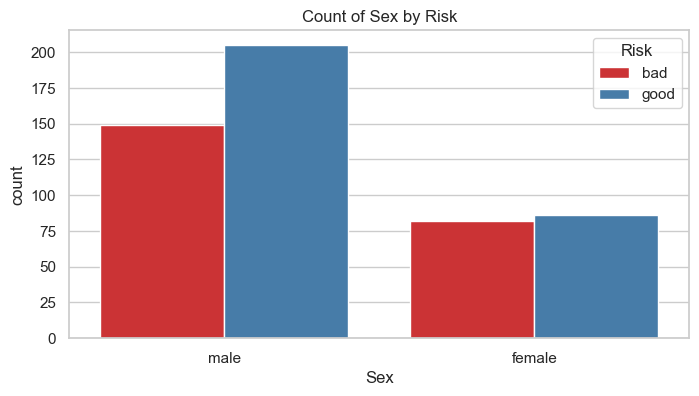

<Figure size 800x400 with 0 Axes>

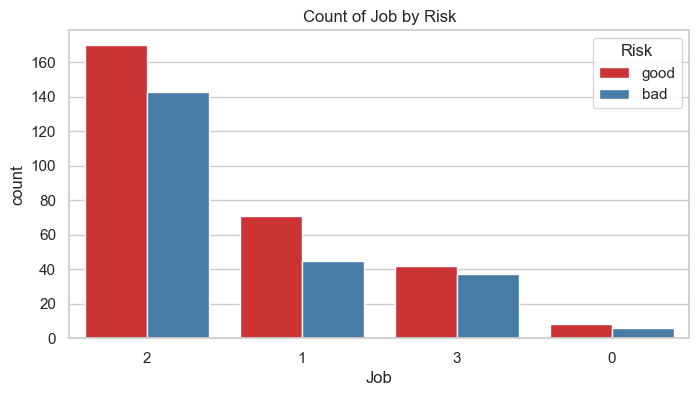

<Figure size 800x400 with 0 Axes>

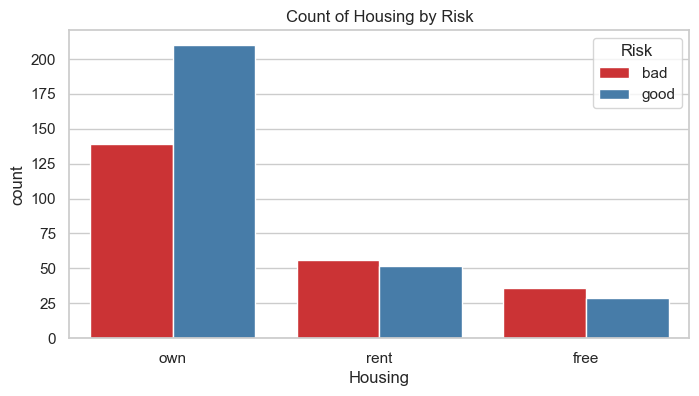

<Figure size 800x400 with 0 Axes>

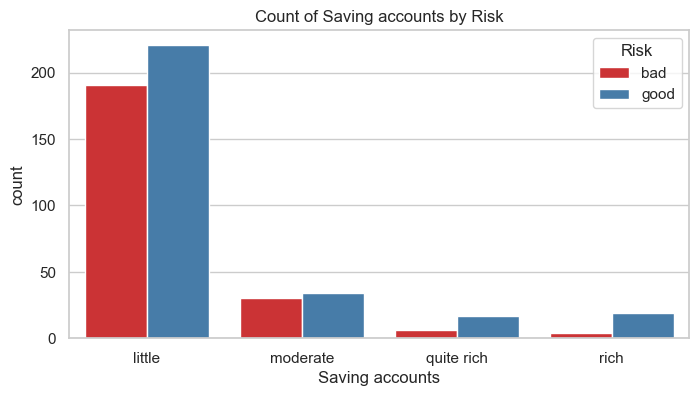

<Figure size 800x400 with 0 Axes>

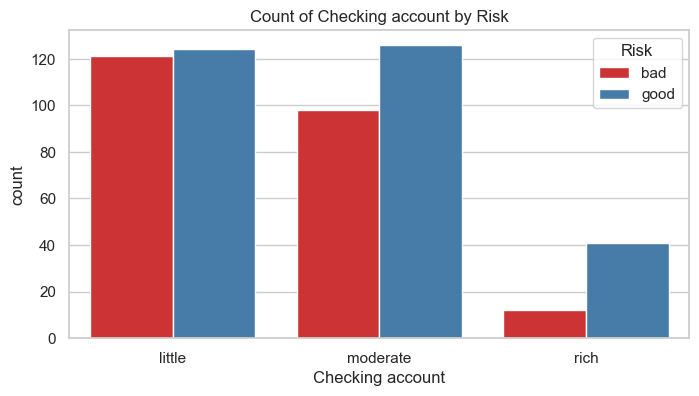

<Figure size 800x400 with 0 Axes>

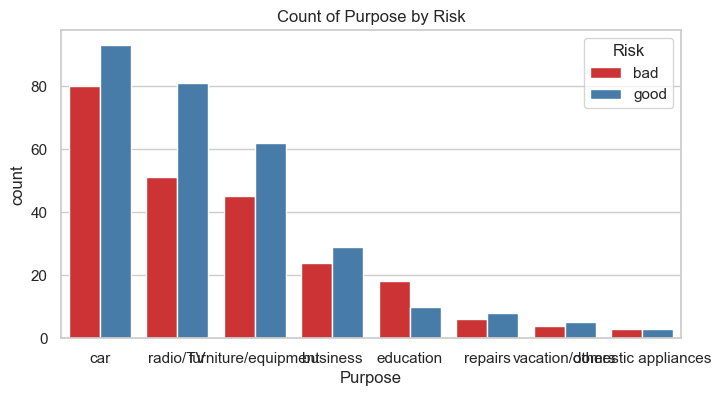

<Figure size 800x400 with 0 Axes>

In [37]:
for i,col in enumerate(categorical_col_):
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col, hue='Risk', palette='Set1',order=df[col].value_counts().index)
    plt.title(f'Count of {col} by Risk')
    plt.show()
    plt.figure(figsize=(8,4))
   
plt.tight_layout()
plt.show()
    

In [38]:
df.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

In [39]:
features=['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose']

In [40]:
target="Risk"

In [41]:
from sklearn.preprocessing import LabelEncoder
import joblib

In [42]:
df_model=df[features+[target]].copy()

In [43]:
df_model

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,22,female,2,own,little,moderate,5951,48,radio/TV,bad
1,45,male,2,free,little,little,7882,42,furniture/equipment,good
2,53,male,2,free,little,little,4870,24,car,bad
3,35,male,3,rent,little,moderate,6948,36,car,good
4,28,male,3,own,little,moderate,5234,30,car,bad
...,...,...,...,...,...,...,...,...,...,...
517,48,male,1,own,little,moderate,1743,24,radio/TV,good
518,30,male,3,own,little,little,3959,36,furniture/equipment,good
519,40,male,3,own,little,little,3857,30,car,good
520,23,male,2,free,little,little,1845,45,radio/TV,bad


In [44]:
cat_col=df_model.select_dtypes(include='object').columns.drop("Risk")

In [45]:
le_dict={}

In [46]:
cat_col

Index(['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'], dtype='object')

In [47]:
for col in cat_col:
    le=LabelEncoder()
    df_model[col]=le.fit_transform(df_model[col])
    le_dict[col]=le
    joblib.dump(le,f"{col}_encoder.pkl")

In [48]:
le_target=LabelEncoder()

In [49]:
df_model[target]=le_target.fit_transform(df_model[target])

In [50]:
df_model[target].value_counts()

Risk
1    291
0    231
Name: count, dtype: int64

In [51]:
joblib.dump(le_target,"target-encoder.pkl")

['target-encoder.pkl']

In [52]:
#1 is good and 0 is bad risk

In [53]:
df_model.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,22,0,2,1,0,1,5951,48,5,0
1,45,1,2,0,0,0,7882,42,4,1
2,53,1,2,0,0,0,4870,24,1,0
3,35,1,3,2,0,1,6948,36,1,1
4,28,1,3,1,0,1,5234,30,1,0


In [54]:
from sklearn.model_selection import train_test_split

In [55]:
x=df_model.drop(target,axis=1)

In [56]:
y=df_model[target]

In [57]:
y

0      0
1      1
2      0
3      1
4      0
      ..
517    1
518    1
519    1
520    0
521    1
Name: Risk, Length: 522, dtype: int64

In [58]:
x

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,22,0,2,1,0,1,5951,48,5
1,45,1,2,0,0,0,7882,42,4
2,53,1,2,0,0,0,4870,24,1
3,35,1,3,2,0,1,6948,36,1
4,28,1,3,1,0,1,5234,30,1
...,...,...,...,...,...,...,...,...,...
517,48,1,1,1,0,1,1743,24,5
518,30,1,3,1,0,0,3959,36,4
519,40,1,3,1,0,0,3857,30,1
520,23,1,2,0,0,0,1845,45,5


In [59]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1)

In [60]:
x_train.shape

(417, 9)

In [61]:
y_train.shape

(417,)

In [62]:
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)
print("After SMOTE:", Counter(y_train))

After SMOTE: Counter({1: 231, 0: 231})


In [63]:
#check the distribution of target variable after resampling
from collections import Counter
print("Before SMOTE:", Counter(y))
print("After SMOTE:", Counter(y_train))
    

Before SMOTE: Counter({1: 291, 0: 231})
After SMOTE: Counter({1: 231, 0: 231})


In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


In [65]:
!pip install xgboost



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [66]:
log_reg = LogisticRegression(
    random_state=42,
    solver='liblinear',  # stable for smaller data
    penalty='l2',
    class_weight='balanced'  # handle imbalance additionally
)
log_reg.fit(x_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [67]:
y_pred = log_reg.predict(x_test)
y_prob = log_reg.predict_proba(x_test)[:, 1]

acc = accuracy_score(y_test, y_pred)


In [68]:
acc

0.5904761904761905

In [69]:
def train_model(model, param_grid, X_train, X_test, y_train, y_test):
    grid = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    return best_model, acc, grid.best_params_

In [70]:
dt = DecisionTreeClassifier(random_state=1,class_weight="balanced")
param_grid = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}



In [71]:
dt_best_model, dt_acc, dt_best_params = train_model(dt, param_grid, x_train, x_test, y_train, y_test)


In [72]:
print("Decision_Tree Accuracy:", dt_acc)
print("Best Parameters:", dt_best_params)

Decision_Tree Accuracy: 0.580952380952381
Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 2}


In [73]:
rf=RandomForestClassifier(random_state=1,class_weight="balanced",n_jobs=-1)

In [74]:
rf_param_grid = {
    'n_estimators': [100, 200],      # Fewer trees
    'max_depth': [5, 10, None],      # Small, medium, unlimited depth
    'min_samples_split': [2, 5],     # Only two levels
    'min_samples_leaf': [1, 2],      # Typical small leaves
    'max_features': ['sqrt'],        # Commonly best for classification
}


In [75]:
rf_best_model, rf_acc, rf_best_params = train_model(
    rf, rf_param_grid, x_train, x_test, y_train, y_test
)

print("RF Best Accuracy:", rf_acc)
print("RF Best Parameters:", rf_best_params)

RF Best Accuracy: 0.6285714285714286
RF Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [76]:
ex_tree_param_grid = {
    'n_estimators': [100, 200],       # Number of trees
    'max_depth': [5, 10, None],       # Tree depth control
    'min_samples_split': [2, 5],      # Minimum samples to split
    'min_samples_leaf': [1, 2],       # Minimum samples in each leaf
    'max_features': ['sqrt', 'log2'], # Features to consider at each split
    'criterion': ['gini', 'entropy']  # Splitting rule
}


In [77]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(random_state=1,n_jobs=-1)

et_best_model, et_acc, et_best_params = train_model(
    et, ex_tree_param_grid, x_train, x_test, y_train, y_test
)

print(" Best Accuracy:", et_acc)
print(" Best Parameters:", et_best_model)


 Best Accuracy: 0.5142857142857142
 Best Parameters: ExtraTreesClassifier(min_samples_leaf=2, n_estimators=200, n_jobs=-1,
                     random_state=1)


In [78]:
xgb_param_grid = {
    'n_estimators': [100, 200],        # Number of boosting rounds
    'max_depth': [3, 5, 7],            # Depth of each tree
    'learning_rate': [0.05, 0.1, 0.2], # Step size shrinkage
    'subsample': [0.8, 1.0],           # Fraction of samples used per tree
    'colsample_bytree': [0.8, 1.0],    # Fraction of features per tree
    'gamma': [0, 0.1],                 # Minimum loss reduction to make a split
}


In [79]:
xgb=XGBClassifier(random_state=1,scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),use_label_encoder=False,eval_metric="logloss")

In [80]:
best_xgb, acc_xgb, xgb_best_params = train_model(
    xgb, xgb_param_grid, x_train, x_test, y_train, y_test
)

print(" Best Accuracy:", acc_xgb)
print(" Best Parameters:", xgb_best_params)

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:199: UserWarning: [21:42:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Best Accuracy: 0.6
 Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}


In [83]:
#save the random forest model
joblib.dump(rf_best_model, 'random_forest_model.pkl')


['random_forest_model.pkl']

In [84]:
#predicting with the saved model
loaded_model = joblib.load('random_forest_model.pkl')
y_loaded_pred = loaded_model.predict(x_test)


In [85]:
accuracy_score(y_test, y_loaded_pred)


0.6285714285714286

In [86]:
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,confusion_matrix

print("Loaded Model Accuracy:", accuracy_score(y_test, y_loaded_pred))
print("Loaded Model ROC AUC:", roc_auc_score(y_test, y_loaded_pred))
print("Loaded Model Classification Report:\n", classification_report(y_test, y_loaded_pred))
print("Loaded Model Confusion Matrix:\n", confusion_matrix(y_test, y_loaded_pred))


Loaded Model Accuracy: 0.6285714285714286
Loaded Model ROC AUC: 0.6194444444444445
Loaded Model Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.56      0.56        45
           1       0.67      0.68      0.68        60

    accuracy                           0.63       105
   macro avg       0.62      0.62      0.62       105
weighted avg       0.63      0.63      0.63       105

Loaded Model Confusion Matrix:
 [[25 20]
 [19 41]]
